# Stream reader basic user

`fetch` and `decode` audio/video data and apply preprocessings that `libavfilter` provides.

In [ ]:
# !conda install -c conda-forge 'ffmpeg<7'

In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt
from torchaudio.io import StreamReader

base_url = "https://download.pytorch.org/torchaudio/tutorial-assets"
AUDIO_URL = f"{base_url}/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
VIDEO_URL = f"{base_url}/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4.mp4"

2.1.0
2.1.0


## Open the source

There are mainly three different sources that streaming API can
handle. Whichever source is used, the remaining processes
(configuring the output, applying preprocessing) are same.

1. Common media formats (resource indicator of string type or file-like object)
2. Audio / Video devices
3. Synthetic audio / video sources

### Local

```python
StreamReader(src="audio.wav")
StreamReader(src="audio.mp3")
```

### Network

```python
# Video on remote server
StreamReader(src="https://example.com/video.mp4")

# Playlist format
StreamReader(src="https://example.com/playlist.m3u")

# RTMP
StreamReader(src="rtmp://example.com:1935/live/app")
```

### File-like objects

```python
# Open as fileobj with seek support
with open("input.mp4", "rb") as src:
    StreamReader(src=src)
```

### Headerless media

If attempting to load headerless raw data, you can use ``format`` and
``option`` to specify the format of the data.

```python
StreamReader(src="raw.s2", format="s16le", option={"sample_rate": "16000"})
```

### Checking the source streams

```python
streamer = StreamReader(AUDIO_URL)
print("The number of source streams:", streamer.num_src_streams)
print(streamer.get_src_stream_info(0))
```

Container formats and playlist formats may contain multiple streams of different media type.

```python
src = "https://devstreaming-cdn.apple.com/videos/streaming/examples/img_bipbop_adv_example_fmp4/master.m3u8"
streamer = StreamReader(src)
print("The number of source streams:", streamer.num_src_streams)
for i in range(streamer.num_src_streams):
    print(streamer.get_src_stream_info(i))
```

## Configure the output streams

### Default streams

When there are multiple streams in the source, it is not immediately clear which stream should be used.

`FFmpeg` implements some heuristics to determine the default stream. The resulting stream index is exposed via

`default_audio_stream` and `default_video_stream`.

### Configuring output streams

Once you know which source stream you want to use, then you can configure output streams with `add_basic_audio_stream()` and `add_basic_video_stream()`.

- The arguments common to both methods are;

`frames_per_chunk`: How many frames at maximum should be returned at each iteration. For audio, the resulting tensor will be the shape of (frames_per_chunk, num_channels). For video, it will be (frames_per_chunk, num_channels, height, width).

`buffer_chunk_size`: The maximum number of chunks to be buffered internally. When the StreamReader buffered this number of chunks and is asked to pull more frames, StreamReader drops the old frames/chunks.

`stream_index`: The index of the source stream.

`decoder`: If provided, override the decoder. Useful if it fails to detect the codec.

`decoder_option`: The option for the decoder.

- For audio output stream, you can provide the following additional parameters to change the audio properties.

`format`: By default the StreamReader returns tensor of float32 dtype, with sample values ranging [-1, 1]. By providing format argument the resulting dtype and value range is changed.

`sample_rate`: When provided, StreamReader resamples the audio on-the-fly.

- For video output stream, the following parameters are available.

`format`: Image frame format. By default StreamReader returns frames in 8-bit 3 channel, in RGB order.

`frame_rate`: Change the frame rate by dropping or duplicating frames. No interpolation is performed.

`width`, `height`: Change the image size.

```python
streamer = StreamReader(...)

# Stream audio from default audio source stream
# 256 frames at a time, keeping the original sampling rate.
streamer.add_basic_audio_stream(
    frames_per_chunk=256,
)

# Stream audio from source stream `i`.
# Resample audio to 8k Hz, stream 256 frames at each
streamer.add_basic_audio_stream(
    frames_per_chunk=256,
    stream_index=i,
    sample_rate=8000,
)
```

```python
# Stream video from default video source stream.
# 10 frames at a time, at 30 FPS
# RGB color channels.
streamer.add_basic_video_stream(
    frames_per_chunk=10,
    frame_rate=30,
    format="rgb24"
)

# Stream video from source stream `j`,
# 10 frames at a time, at 30 FPS
# BGR color channels with rescaling to 128x128
streamer.add_basic_video_stream(
    frames_per_chunk=10,
    stream_index=j,
    frame_rate=30,
    width=128,
    height=128,
    format="bgr24"
)
```

You can check the resulting output streams in a similar manner as checking the source streams.

```python
for i in range(streamer.num_out_streams):
    print(streamer.get_out_stream_info(i))
```

If you want to remove an output stream, you can do so with remove_stream() method.

```python
streamer.remove_stream(0)
```

## Streaming

```python
streamer = StreamReader(...)
streamer.add_basic_audio_stream(...)
streamer.add_basic_video_stream(...)

for chunks in streamer.stream():
    audio_chunk, video_chunk = chunks
    ...
```

## Example

### Open the source media

In [4]:
streamer = StreamReader(VIDEO_URL)

for i in range(streamer.num_src_streams):
    print(streamer.get_src_stream_info(i))

SourceVideoStream(media_type='video', codec='h264', codec_long_name='H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10', format='yuv420p', bit_rate=9958354, num_frames=6175, bits_per_sample=8, metadata={'creation_time': '2018-07-24T17:40:48.000000Z', 'encoder': 'AVC Coding', 'handler_name': '\x1fMainconcept Video Media Handler', 'language': 'eng'}, width=1920, height=1080, frame_rate=29.97002997002997)
SourceAudioStream(media_type='audio', codec='aac', codec_long_name='AAC (Advanced Audio Coding)', format='fltp', bit_rate=317375, num_frames=9658, bits_per_sample=0, metadata={'creation_time': '2018-07-24T17:40:48.000000Z', 'handler_name': '#Mainconcept MP4 Sound Media Handler', 'language': 'eng'}, sample_rate=48000.0, num_channels=2)


### Configure the output streams

In [5]:
# fmt: off
# Audio stream with 8k Hz
streamer.add_basic_audio_stream(
    frames_per_chunk=8000,
    sample_rate=8000,
)

# Audio stream with 16k Hz
streamer.add_basic_audio_stream(
    frames_per_chunk=16000,
    sample_rate=16000,
)

# Video stream with 960x540 at 1 FPS.
streamer.add_basic_video_stream(
    frames_per_chunk=1,
    frame_rate=1,
    width=960,
    height=540,
    format="rgb24",
)

# Video stream with 320x320 (stretched) at 3 FPS, grayscale
streamer.add_basic_video_stream(
    frames_per_chunk=3,
    frame_rate=3,
    width=320,
    height=320,
    format="gray",
)
# fmt: on

Check the output streams

In [6]:
for i in range(streamer.num_out_streams):
    print(streamer.get_out_stream_info(i))

OutputAudioStream(source_index=1, filter_description='aresample=8000,aformat=sample_fmts=fltp', media_type='audio', format='fltp', sample_rate=8000.0, num_channels=2)
OutputAudioStream(source_index=1, filter_description='aresample=16000,aformat=sample_fmts=fltp', media_type='audio', format='fltp', sample_rate=16000.0, num_channels=2)
OutputVideoStream(source_index=0, filter_description='fps=1,scale=width=960:height=540,format=pix_fmts=rgb24', media_type='video', format='rgb24', width=960, height=540, frame_rate=1.0)
OutputVideoStream(source_index=0, filter_description='fps=3,scale=width=320:height=320,format=pix_fmts=gray', media_type='video', format='gray', width=320, height=320, frame_rate=3.0)


Remove the second audio stream.

In [7]:
streamer.remove_stream(1)
for i in range(streamer.num_out_streams):
    print(streamer.get_out_stream_info(i))

OutputAudioStream(source_index=1, filter_description='aresample=8000,aformat=sample_fmts=fltp', media_type='audio', format='fltp', sample_rate=8000.0, num_channels=2)
OutputVideoStream(source_index=0, filter_description='fps=1,scale=width=960:height=540,format=pix_fmts=rgb24', media_type='video', format='rgb24', width=960, height=540, frame_rate=1.0)
OutputVideoStream(source_index=0, filter_description='fps=3,scale=width=320:height=320,format=pix_fmts=gray', media_type='video', format='gray', width=320, height=320, frame_rate=3.0)


### Streaming

Jump to the 10 second point.

In [8]:
streamer.seek(10)

Now, let’s finally iterate over the output streams.

In [9]:
n_ite = 3
waveforms, vids1, vids2 = [], [], []
for i, (waveform, vid1, vid2) in enumerate(streamer.stream()):
    waveforms.append(waveform)
    vids1.append(vid1)
    vids2.append(vid2)
    if i + 1 == n_ite:
        break

In [10]:
print(waveforms[0].shape)
print(vids1[0].shape)
print(vids2[0].shape)

torch.Size([8000, 2])
torch.Size([1, 3, 540, 960])
torch.Size([3, 1, 320, 320])


Let’s visualize what we received.

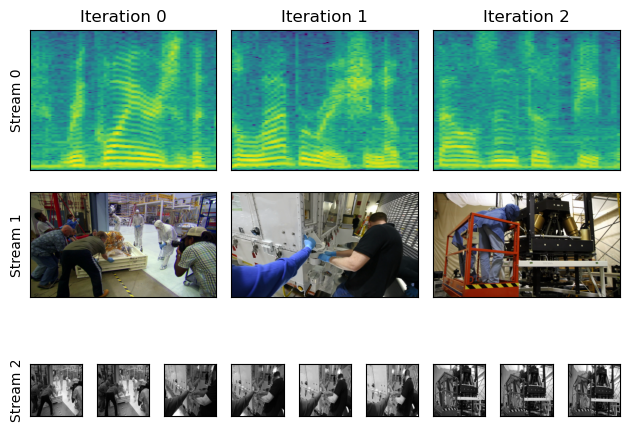

In [11]:
k = 3
fig = plt.figure()
gs = fig.add_gridspec(3, k * n_ite)
for i, waveform in enumerate(waveforms):
    ax = fig.add_subplot(gs[0, k * i : k * (i + 1)])
    ax.specgram(waveform[:, 0], Fs=8000)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(f"Iteration {i}")
    if i == 0:
        ax.set_ylabel("Stream 0")
for i, vid in enumerate(vids1):
    ax = fig.add_subplot(gs[1, k * i : k * (i + 1)])
    ax.imshow(vid[0].permute(1, 2, 0))  # NCHW->HWC
    ax.set_yticks([])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Stream 1")
for i, vid in enumerate(vids2):
    for j in range(3):
        ax = fig.add_subplot(gs[2, k * i + j : k * i + j + 1])
        ax.imshow(vid[j].permute(1, 2, 0), cmap="gray")
        ax.set_yticks([])
        ax.set_xticks([])
        if i == 0 and j == 0:
            ax.set_ylabel("Stream 2")
plt.tight_layout()